<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Assignment_12/DNN_assignment_12_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [15]:

import os
import random
import torch
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassAccuracy
import torch.optim as optim
from tqdm import tqdm
import time

#Dataset Processing

In [16]:
# Load dataset
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
val_ratio = 0.1
generator = torch.Generator().manual_seed(seed)
use_reduced_data = True

transform = transforms.Compose([
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-30, 30)),
    # transforms.ColorJitter(),
    transforms.RandAugment(num_ops=2, magnitude=7),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transformTest = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

CIFAR10Dataset = torchvision.datasets.CIFAR10(root='.', download=True)
full_train_dataset = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=None)
test_dataset = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transformTest)

if use_reduced_data:
    total_reduced_size = 10000
    selected_indices = torch.randperm(len(full_train_dataset), generator=generator)[:total_reduced_size]
else:
    selected_indices = torch.arange(len(full_train_dataset))

val_size = int(len(selected_indices) * val_ratio)
train_size = len(selected_indices) - val_size
train_indices, val_indices = random_split(selected_indices, [train_size, val_size], generator=generator)


train_dataset = Subset(
    torchvision.datasets.CIFAR10(root='.', train=True, download=False, transform=transform),
    train_indices.indices
)

val_dataset = Subset(
    torchvision.datasets.CIFAR10(root='.', train=True, download=False, transform=transformTest),
    val_indices.indices
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())

#Pretrained model

In [17]:
import torch.nn as nn
from torchvision.models import resnet50, mobilenet_v3_large, resnet18

def get_resNet18(num_classes=10):
    model = resnet18(pretrained=True)

    # Adjust first conv stride for 32x32 input
    # ResNet18's first conv is model.conv1
    model.conv1.stride = (1, 1)

    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last two layers of the feature extractor (layer4 and avgpool)
    # and the fully connected layer
    for param in model.layer4.parameters():
        param.requires_grad = True
    for param in model.avgpool.parameters():
        param.requires_grad = True
    for param in model.fc.parameters():
        param.requires_grad = True


    # Replace final classification layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

#Small CNN model

In [18]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Changed input channels to 3 for RGB
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Calculate the flattened size dynamically
        # Input size: 32x32
        # After conv1 and pool: (32/2) x (32/2) = 16x16, with 16 channels -> 16*16*16
        # After conv2 and pool: (16/2) x (16/2) = 8x8, with 32 channels -> 8*8*32 = 2048
        self.fc1 = nn.Linear(32 * 8 * 8, 128) # Corrected input features to 32 * 8 * 8
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 3x32x32 -> 16x16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16x16 -> 32x8x8
        x = x.view(x.size(0), -1)             # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#training funtion

In [19]:
def train(model, train_loader, val_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    model.to(device)
    results = []
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()

        for inputs, labels in (train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        val_acc, val_loss = validation(model, val_loader, device, show_metrics=False)
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}({time.time() - start_time:.2f}s)  - accuracy: {train_acc:.4f}  - loss: {train_loss:.4f}  - val_accuracy: {val_acc:.4f}  - val_loss: {val_loss:.4f}")
        results.append([train_acc, train_loss, val_acc, val_loss])
    return results

def validation(model, test_loader, device, show_metrics=True):
    metric = MulticlassAccuracy(num_classes=10).to(device)
    model.eval()
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in (test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            metric.update(outputs, labels)
            total_loss += loss.item()

    accuracy_val = metric.compute().item()
    avg_loss = total_loss / len(test_loader)

    if show_metrics:
        print(f"Validation Accuracy: {accuracy_val:.4f} Loss: {avg_loss:.4f}")
    return accuracy_val, avg_loss


def train_knowledge_distillation(teacher, student, train_loader, val_loader, epochs, learning_rate, T, alpha, device):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(student.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    results = []

    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()
        for inputs, labels in (train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                teacher_logits = teacher(inputs)
            student_logits = student(inputs)

            label_loss = criterion(student_logits, labels)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_targets_loss = F.kl_div(soft_prob, soft_targets, reduction='batchmean') * (T ** 2)
            loss = alpha * soft_targets_loss + (1 - alpha) * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(student_logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        val_acc, val_loss = validation(student, val_loader, device, show_metrics=False)
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}({time.time() - start_time:.2f}s) - accuracy: {train_acc:.4f}  - loss: {train_loss:.4f}  - val_accuracy: {val_acc:.4f}  - val_loss: {val_loss:.4f}")
        results.append([train_acc, train_loss, val_acc, val_loss])
    return results

#ploating funtion

In [20]:
import matplotlib.pyplot as plt
def plot_history(history, title):
    # Unpack the history
    train_acc = [row[0] for row in history]
    train_loss = [row[1] for row in history]
    val_acc   = [row[2] for row in history]
    val_loss  = [row[3] for row in history]
    epochs = range(1, len(history) + 1)

    # Plotting
    plt.figure(figsize=(12, 5))

    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.suptitle(f'{title}', fontsize=16)
    plt.tight_layout()
    plt.show()

#Model Training

In [21]:
model = get_resNet18().cuda()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# trained_model, history_resNet50 = train(model, train_loader, val_loader, device, epochs=30, lr=0.001)
epochs = 30
learning_rate = 1e-3
history_resnet50 = train(model, train_loader, val_loader, epochs, learning_rate, device)
validation(model, test_loader, device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30(10.04s)  - accuracy: 0.4747  - loss: 1.7044  - val_accuracy: 0.6225  - val_loss: 1.3646
Epoch 2/30(9.99s)  - accuracy: 0.5761  - loss: 1.4460  - val_accuracy: 0.7124  - val_loss: 1.1577
Epoch 3/30(10.50s)  - accuracy: 0.6018  - loss: 1.3881  - val_accuracy: 0.7233  - val_loss: 1.1456
Epoch 4/30(10.04s)  - accuracy: 0.6283  - loss: 1.3391  - val_accuracy: 0.7070  - val_loss: 1.1664
Epoch 5/30(10.22s)  - accuracy: 0.6353  - loss: 1.3174  - val_accuracy: 0.7347  - val_loss: 1.1100
Epoch 6/30(9.65s)  - accuracy: 0.6452  - loss: 1.2888  - val_accuracy: 0.7436  - val_loss: 1.0833
Epoch 7/30(8.54s)  - accuracy: 0.6550  - loss: 1.2651  - val_accuracy: 0.7427  - val_loss: 1.0833
Epoch 8/30(9.65s)  - accuracy: 0.6653  - loss: 1.2487  - val_accuracy: 0.7529  - val_loss: 1.0570
Epoch 9/30(9.70s)  - accuracy: 0.6781  - loss: 1.2127  - val_accuracy: 0.7647  - val_loss: 1.0418
Epoch 10/30(9.45s)  - accuracy: 0.6942  - loss: 1.2021  - val_accuracy: 0.7452  - val_loss: 1.0658
Epoch 11/30(8.6

(0.791100025177002, 0.9808262605575999)

In [22]:
scratch_student = SmallCNN().to(device)
history_scratch = train(scratch_student, train_loader, val_loader, epochs, learning_rate, device)
validation(scratch_student, test_loader, device)


Epoch 1/30(8.12s)  - accuracy: 0.2761  - loss: 2.0595  - val_accuracy: 0.4230  - val_loss: 1.8091
Epoch 2/30(8.73s)  - accuracy: 0.3632  - loss: 1.8702  - val_accuracy: 0.4505  - val_loss: 1.6788
Epoch 3/30(7.70s)  - accuracy: 0.4137  - loss: 1.7812  - val_accuracy: 0.4794  - val_loss: 1.6073
Epoch 4/30(8.24s)  - accuracy: 0.4289  - loss: 1.7434  - val_accuracy: 0.4909  - val_loss: 1.5681
Epoch 5/30(8.62s)  - accuracy: 0.4471  - loss: 1.6990  - val_accuracy: 0.5299  - val_loss: 1.5447
Epoch 6/30(7.48s)  - accuracy: 0.4539  - loss: 1.6734  - val_accuracy: 0.5610  - val_loss: 1.4922
Epoch 7/30(8.55s)  - accuracy: 0.4759  - loss: 1.6539  - val_accuracy: 0.5377  - val_loss: 1.5125
Epoch 8/30(8.67s)  - accuracy: 0.4889  - loss: 1.6290  - val_accuracy: 0.5710  - val_loss: 1.4664
Epoch 9/30(7.54s)  - accuracy: 0.4884  - loss: 1.6157  - val_accuracy: 0.5709  - val_loss: 1.4561
Epoch 10/30(8.66s)  - accuracy: 0.5008  - loss: 1.6012  - val_accuracy: 0.5631  - val_loss: 1.4389
Epoch 11/30(8.66s) 

(0.6277999877929688, 1.3521294115455287)

In [24]:

T, alpha = 4, 0.8

history_kd = train_knowledge_distillation(model, scratch_student, train_loader, val_loader, epochs, learning_rate, T=T, alpha=alpha, device=device)
validation(scratch_student, test_loader, device)

Epoch 1/30(8.74s) - accuracy: 0.5556  - loss: 0.9300  - val_accuracy: 0.6099  - val_loss: 1.3989
Epoch 2/30(8.45s) - accuracy: 0.5466  - loss: 0.9091  - val_accuracy: 0.5993  - val_loss: 1.4091
Epoch 3/30(9.22s) - accuracy: 0.5504  - loss: 0.8992  - val_accuracy: 0.6103  - val_loss: 1.4012
Epoch 4/30(9.02s) - accuracy: 0.5494  - loss: 0.8901  - val_accuracy: 0.6108  - val_loss: 1.3695
Epoch 5/30(8.08s) - accuracy: 0.5527  - loss: 0.8807  - val_accuracy: 0.6157  - val_loss: 1.3636
Epoch 6/30(9.24s) - accuracy: 0.5532  - loss: 0.8761  - val_accuracy: 0.6044  - val_loss: 1.3788
Epoch 7/30(9.11s) - accuracy: 0.5556  - loss: 0.8725  - val_accuracy: 0.6069  - val_loss: 1.3527
Epoch 8/30(8.00s) - accuracy: 0.5633  - loss: 0.8600  - val_accuracy: 0.5984  - val_loss: 1.3872
Epoch 9/30(9.16s) - accuracy: 0.5678  - loss: 0.8551  - val_accuracy: 0.6352  - val_loss: 1.3433
Epoch 10/30(9.17s) - accuracy: 0.5712  - loss: 0.8489  - val_accuracy: 0.6169  - val_loss: 1.3636
Epoch 11/30(8.04s) - accuracy

(0.656499981880188, 1.2928315765538794)

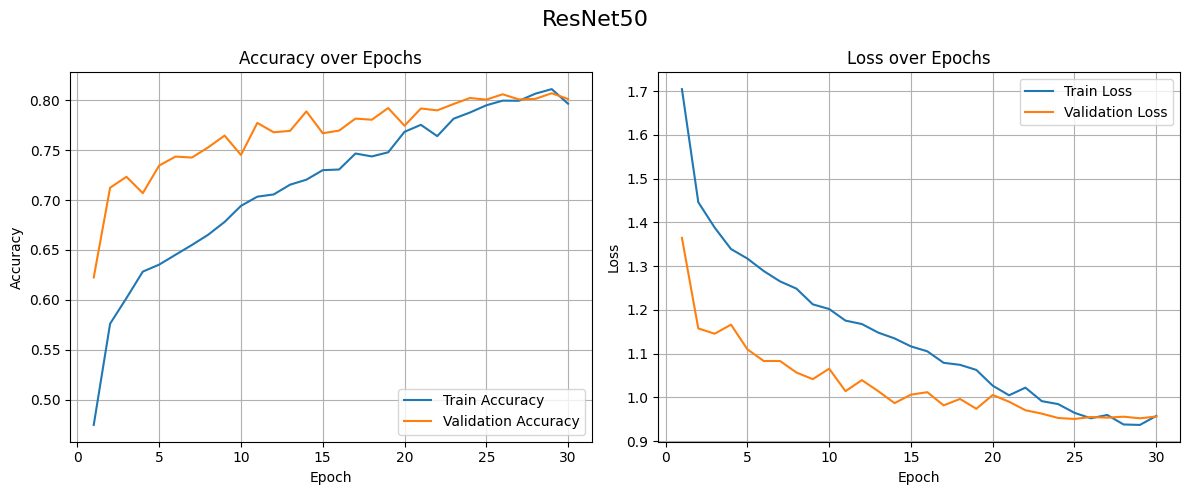

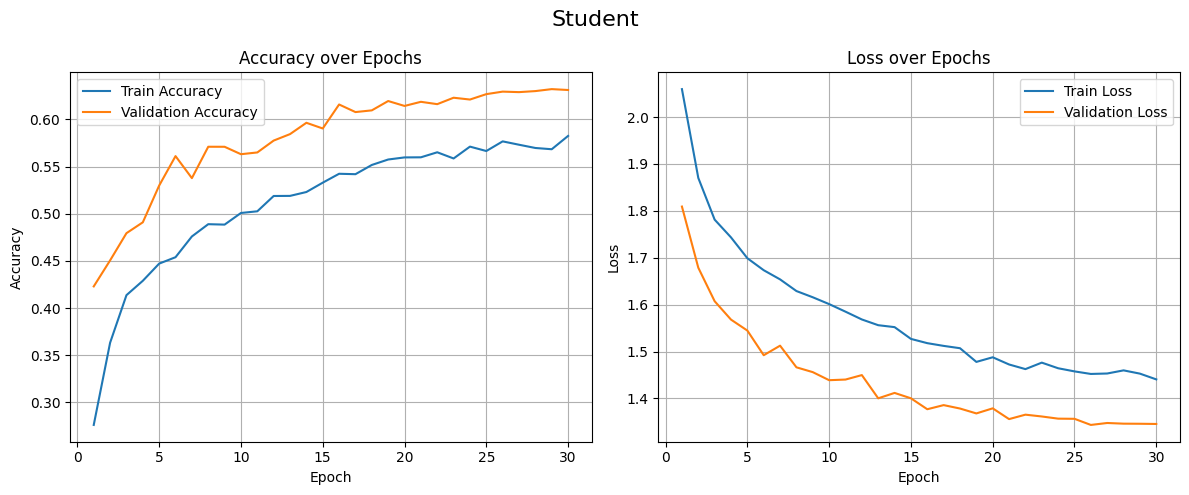

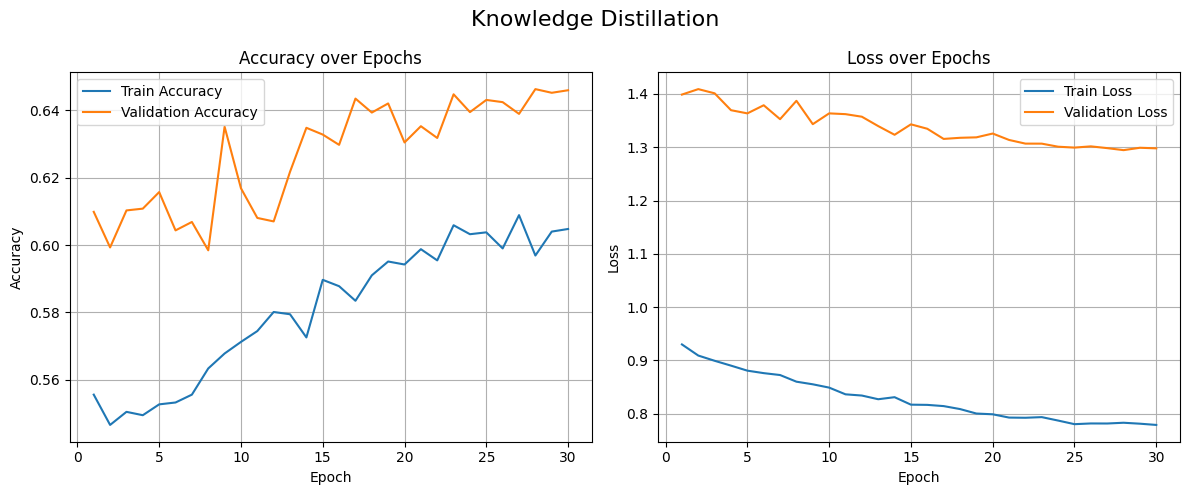

In [26]:
plot_history(history_resnet50, 'ResNet50')
plot_history(history_scratch, 'Student')
plot_history(history_kd, 'Knowledge Distillation')